In [193]:
import branch_length
import distributions

import altair as alt
import numpy as np
import pandas as pd

alt.renderers.enable("notebook")

import importlib 
importlib.reload(branch_length)
importlib.reload(distributions)

<module 'distributions' from '/home/ematsen/re/libsbn/python/distributions.py'>

In [195]:
def plot_functions(f_true, f_approx):
    x_vals = np.linspace(0.1, 5, 40)
    x_transpose = np.transpose(np.array([x_vals]))
    data = pd.DataFrame({"x": x_vals, "truth": f_true(np.transpose(np.array([x_vals]))), 
                         "approx": f_approx(np.transpose(np.array([x_vals])))})
    return alt.Chart(data.melt(id_vars=["x"])).mark_line().encode(
        x='x',
        y='value',
        color='variable'
    )

In [214]:
stepsz = 0.05
grad_clip = 100.
d = distributions.Normal(1)
true_loc = np.array([2.])
true_shape = np.array([1.])
phylo_log_like = lambda x: d.log_prob(x, true_loc, true_shape)
phylo_log_like_grad = lambda x: d.log_prob_grad(x, true_loc, true_shape)

loc = np.array([1.])
shape = np.array([0.5])

[0.32565688]
before
[2.] [1.22836991] [0.08371716]
[1.] [0.80528073] [-0.03175609]
after
[2.] [1.31208706] [0.08371716]
[1.] [0.77352464] [-0.03175609]


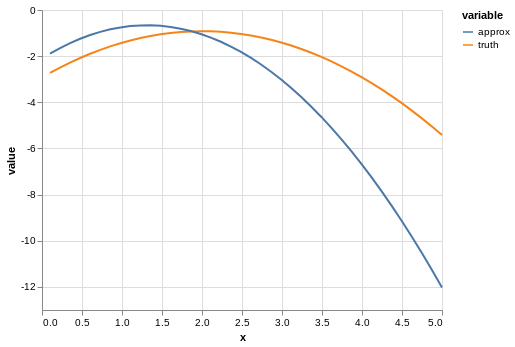

In [220]:
x = d.sample(loc, shape, 1)
x_transpose = np.transpose(np.array([x]))
loc_grad, shape_grad = branch_length.param_grad(d, phylo_log_like_grad(x), x, loc, shape)

print(x)
print("before")
print(true_loc, loc, loc_grad*stepsz)
print(true_shape, shape, shape_grad*stepsz)

loc += np.clip(loc_grad*stepsz, -grad_clip, grad_clip)
shape += np.clip(shape_grad*stepsz, -grad_clip, grad_clip)

print("after")
print(true_loc, loc, loc_grad*stepsz)
print(true_shape, shape, shape_grad*stepsz)

plot_functions(phylo_log_like, lambda x: d.log_prob(x, loc, shape))